In [5]:
import numpy as np

class PDE_Heat:

    def __init__(self, a, b, nx, t_final, sigma, D, boundary_conds):

        self.a = a
        self.b = b
        self.nx = nx
        self.t_final = t_final
        self.sigma = sigma
        self.D = D
        self.boundary_conds = boundary_conds

        self.no_of_panels_x = nx + 1
        self.total_no_of_points_x = nx + 2

        self.dx = (self.b - self.a)/self.no_of_panels_x
        self.dt = (sigma/D)*self.dx**2

        self.x = np.linspace(self.a, self.b, self.total_no_of_points_x)
        self.t = np.arange(0, t_final, self.dt)

        self.total_no_of_points_t = len(self.t)

        self.x_t0, self.t_xa, self.t_xb = boundary_conds

    def createW(self):
        W = np.zeros((self.total_no_of_points_t, self.total_no_of_points_x))
        W[0,1:-1] = self.x_t0(np.linspace(self.a, self.b, self.nx))
        W[:,0] = self.t_xa(self.t)
        W[:,-1] = self.t_xb(self.b)

        return W

    def createForwardA(self):
        m = self.total_no_of_points_x
        A = np.zeros((m,m))

        j_ind_low = np.arange(0, m-2, 1)
        i_ind = np.arange(1, m-1, 1)
        j_ind_high = np.arange(2, m, 1)

        A[0,0] = A[-1,-1] = 1
        A[i_ind, j_ind_low] = self.sigma
        A[i_ind, i_ind] = 1 - 2*self.sigma
        A[i_ind, j_ind_high] = self.sigma

        return A

    def createBackwardA(self):
        pass

    def forward(self):
        W = self.createW()
        A = self.createForwardA()

        for i in range(0, self.total_no_of_points_t - 1):
            W[i+1,:] = A@W[i,:]
        
        return W
    
    def backward(self):
        pass

In [6]:
abc = PDE_Heat(0, 1, 48, 0.1, 1/3, 1, [lambda x: np.square(np.sin(2*np.pi*x)), lambda x:0, lambda x:0])

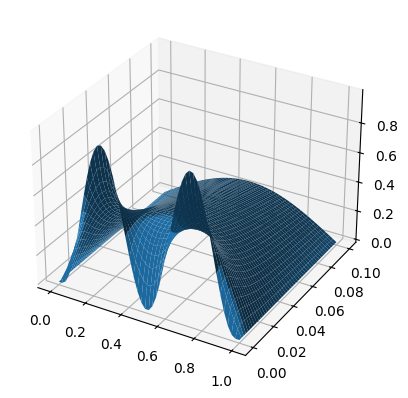

In [8]:
import matplotlib.pyplot as plt

xx, tt = np.meshgrid(abc.x, abc.t)
fig, ax = plt.subplots(subplot_kw={"projection":"3d"})
ax.plot_surface(xx,tt,abc.forward())
plt.show()

In [21]:
import numpy as np

class Integrators:

    def __init__(self, a, b, n, f: callable):
        self.a = a
        self.b = b
        self.n = n # no of points between a and b excluding a and b
        self.f = f

        self.no_of_panels = n + 1
        self.total_no_of_points = n + 2

        self.dx = (self.b - self.a)/self.no_of_panels

        self.x = np.linspace(self.a, self.b, self.total_no_of_points)

        self.fx = self.f(self.x)

    def trapezoid(self):
        return (self.dx/2)*(self.fx[0] + self.fx[-1] + 2*np.sum(self.fx[1:-1]))

    def simpsons13(self):
        return (self.dx/3)*(self.fx[0] + self.fx[-1] + 4*np.sum(self.fx[1:-1:2]) + 2*np.sum(self.fx[2:-1:2]))

    def simpsons38(self):
        return (3*self.dx/8)*(self.fx[0] + self.fx[-1] + 3*np.sum(self.fx[1:-1:3]) + 3*np.sum(self.fx[2:-1:3]) + 2*np.sum(self.fx[3:-1:3]))

I = Integrators(0,np.pi,9,lambda x: np.sin(x))

print(I.trapezoid())
print(I.simpsons13())
print(I.simpsons38())

1.9835235375094546
2.0001095173150043
1.9877049973133143


In [ ]:
class NODES:

    N: int
    dx: float
    iters: int
    state: dict = {"rk4":{}}
    evolvers: dict = {}
    state_history: dict = {"rk4":{}}
    
    def __init__(self, N, dx, iters, state, evolvers):
        self.N = N
        self.dx = dx
        self.iters = iters

        for method in self.state:
            self.state[method] = state

        self.evolvers = evolvers

        for method in self.self.state_history:
            self.state_history[method]["x"] = []
            for i in range(0, self.N):
                self.state_history[method][f"y{i}"] = []

        for i in range(0, self.iters):
            for method in self.state_history:
                for yn in self.state_history[method]:
                    self.state_history[method][yn].append(self.state[method][yn])

            self.state["rk4"] = self.rk4(self.state["rk4"].copy())

    def rk4(self, state):
        _temp = {}
        G1 = {}
        G2 = {}
        G3 = {}
        G4 = {}
        Gs = [G1,G2, G3,G4]

        for idx, Gi in enumerate(Gs):
            if idx == 0:
                Gsw = 0
                _temp = {k:v for k,v in state.items() if k != "x"}
            else:
                Gsw = 0.5
                if idx == 